In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats

//anaconda/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.3.1 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


# Initial Investigation Functions

In [57]:
url = '/Users/Kristen/Cryptocurrency/exchange_rates.csv'

def import_data(url):
    data = pd.read_csv(url, names=['ID', 'Time', 'BTC', 'ETH', 'Rate'])
    data.index = pd.to_datetime(data['Time'], unit='s')
    del data['Time']
    del data.index.name
    
    return data

def initial_look(data):
    data['Rate'].plot(grid=True)
    plt.xlabel('Time (HH:MM:SS)')
    plt.ylabel('BTC->ETH Exchange Rate')
    plt.show()
    
def pct_change(data):
    pct_change_per_time = data[['Rate']].pct_change()
    pct_change_per_time.fillna(0, inplace=True)
    minutes = pct_change_per_time.resample('min').mean()

    minutes[['Rate']].plot()
    plt.xlabel('Time (min)')
    plt.ylabel('Percent Change BTC->ETH Exchange Rate')
    plt.show()
    
def cumulative_return(data):
    pct_change_per_time = data[['Rate']].pct_change()
    cum_return = (1+pct_change_per_time).cumprod()
    cum_return.plot(grid=True)
    plt.xlabel('Time (sec)')
    plt.ylabel('Cumulative Return (100%)')
    plt.show()

    return cum_return

def cumulative_return_per_unit_time(cum_return, time):
    cum_return_per_min = cum_return.resample(time).mean()
    cum_return_per_min.plot(grid=True)
    plt.xlabel('Time (%s)' % time)
    plt.ylabel('Cumulative Return (100%)')
    plt.show()

**Plot the Exchange Rate over the time presented. Look at the descriptions of the DataFrame**

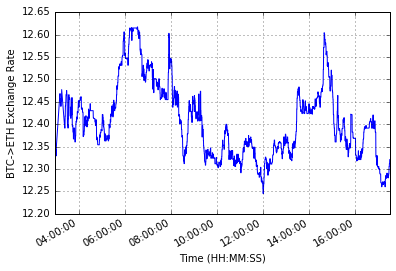

,ID,Rate
count,9600.000000,9600.000000
mean,13975.500000,12.406609
std,2771.425626,0.082521
min,9176.000000,12.245086
25%,11575.750000,12.342434
50%,13975.500000,12.393948
75%,16375.250000,12.456305
max,18775.000000,12.617057


In [58]:
data = import_data(url)
recent_data = data[-9600:]
initial_look(recent_data)
recent_data.describe()

**Plot the percent return with the resolution per minute**

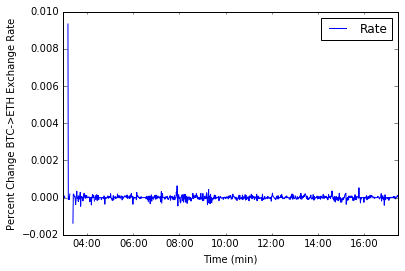

In [35]:
pct_change(recent_data)

**Plot the cumulative percent return with a variety of resolutions**

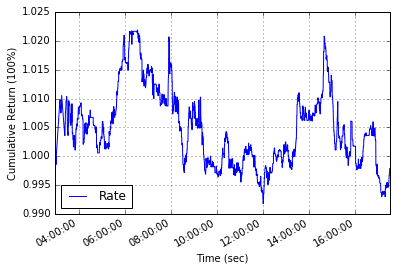

In [39]:
cum_return = cumulative_return(recent_data)

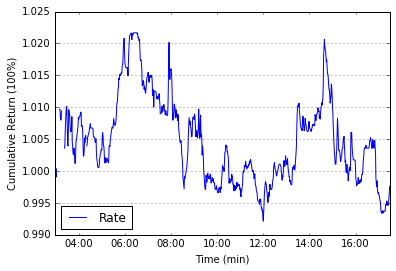

In [44]:
cumulative_return_per_unit_time(cum_return, 'min')

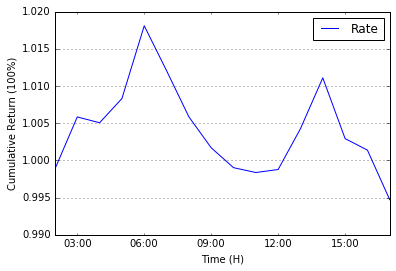

In [53]:
cumulative_return_per_unit_time(cum_return, 'H')

# Strategy Functions

In [98]:
def rolling_avg(data, window):
    df = data[['Rate']].rolling(window=window, min_periods=1, center=False).mean()
    return df


def extract_adjusted_slope(df, window):
    
    results = pd.DataFrame(index=df.index)
    number_entries = len(df.index)
    xdata = np.linspace(0, number_entries, number_entries)
    
    for i in xrange(0, number_entries):
        if len(df) - i >= window:
            end = window + i
            current_slice = df.iloc[i:end,:]
            idx = current_slice.tail(1).iloc[0]
            current_adj_slope = rolling_stats(current_slice, xdata[i:end])
            results.set_value(idx.name, 'Adj Slope', current_adj_slope)
    
    results.dropna(inplace=True)
    return results
            
    
def rolling_stats(moving_avg, xdata):    
    
    log_of_rate = np.log(moving_avg['Rate'])
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(xdata, log_of_rate)
    annualized_return = (np.exp(slope)**252) - 1
    coeff_determination = rvalue**2
    adj_slope = annualized_return * coeff_determination
    
    return adj_slope

    

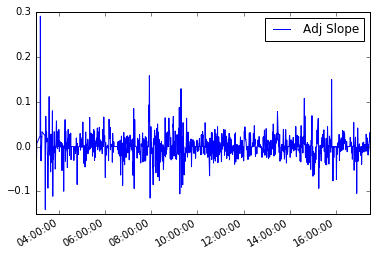

In [179]:
moving_avg = rolling_avg(recent_data, 10)
results = extract_adjusted_slope(moving_avg, 10)
results.head()
results.plot()

## Back Test the Ajdusted Slope Strategy

In [185]:
signals = pd.DataFrame(index=results.index)
signals['signal'] = 0.0

long_signals = np.where(results['Adj Slope'] >= 0.0, 1.0, 0.0)
signals['signal'] = long_signals
signals['positions'] = signals['signal'].diff()
signals.head()

,signal,positions
2017-08-06 02:59:10,0.0,NaN
2017-08-06 02:59:15,0.0,0.0
2017-08-06 02:59:20,0.0,0.0
2017-08-06 02:59:30,0.0,0.0
2017-08-06 02:59:35,0.0,0.0


In [186]:
print len(signals)
print len(moving_avg)
#moving_avg[4:].head()

concat = pd.concat([moving_avg[9:], signals], axis=1)
concat

9591
9600


,Rate,signal,positions
2017-08-06 02:59:10,12.333957,0.0,NaN
2017-08-06 02:59:15,12.332431,0.0,0.0
2017-08-06 02:59:20,12.330905,0.0,0.0
2017-08-06 02:59:30,12.329379,0.0,0.0
2017-08-06 02:59:35,12.329973,0.0,0.0
2017-08-06 02:59:40,12.330567,0.0,0.0
2017-08-06 02:59:45,12.331161,0.0,0.0
2017-08-06 02:59:50,12.331755,0.0,0.0
2017-08-06 02:59:55,12.332839,0.0,0.0
2017-08-06 03:00:00,12.333922,1.0,1.0


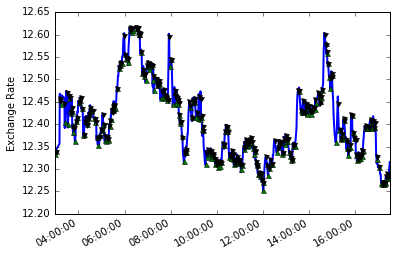

In [187]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Exchange Rate')

#aapl['Adj Close'].plot(ax=ax1, color='r', lw=2.)

concat['Rate'].plot(ax=ax1, lw=2.)

#Plot the buy signals
ax1.plot(concat.loc[concat.positions == 1.0].index, concat.Rate[concat.positions == 1.0], '^', markersize=5, color='green')

#Plot the sell signals
ax1.plot(concat.loc[concat.positions == -1.0].index, concat.Rate[concat.positions == -1.0], 'v', markersize=5, color='k')

plt.show()

In [188]:
initial_capital = float(1000.0)
positions = pd.DataFrame(index=concat.index).fillna(0.0)
positions["BTC->ETH"] = 1*signals['signal']

portfolio = positions.multiply(concat['Rate'], axis=0)

diff_positions = positions.diff()

portfolio['holdings'] = (positions.multiply(concat['Rate'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (diff_positions.multiply(concat['Rate'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()

In [189]:
portfolio

,BTC->ETH,holdings,cash,total,returns
2017-08-06 02:59:10,0.000000,0.000000,NaN,NaN,NaN
2017-08-06 02:59:15,0.000000,0.000000,1000.000000,1000.000000,NaN
2017-08-06 02:59:20,0.000000,0.000000,1000.000000,1000.000000,0.000000e+00
2017-08-06 02:59:30,0.000000,0.000000,1000.000000,1000.000000,0.000000e+00
2017-08-06 02:59:35,0.000000,0.000000,1000.000000,1000.000000,0.000000e+00
2017-08-06 02:59:40,0.000000,0.000000,1000.000000,1000.000000,0.000000e+00
2017-08-06 02:59:45,0.000000,0.000000,1000.000000,1000.000000,0.000000e+00
2017-08-06 02:59:50,0.000000,0.000000,1000.000000,1000.000000,0.000000e+00
2017-08-06 02:59:55,0.000000,0.000000,1000.000000,1000.000000,0.000000e+00
2017-08-06 03:00:00,12.333922,12.333922,987.666078,1000.000000,0.000000e+00


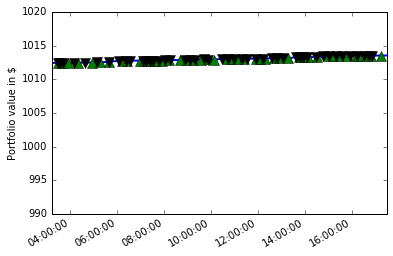

In [165]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel="Portfolio value in $")

portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, portfolio.total[signals.positions == 1.0], '^', markersize=10, color='green')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, portfolio.total[signals.positions == -1.0], 'v', markersize=10, color='k')

plt.ylim(990,1020)
plt.show()